# How to train your DragoNN tutorial 5: 
## Functional variant characterization for non-coding SNPs within the SPI1 motif 

This tutorial is a supplement to the DragoNN manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data: SPI1 ChiP-seq and experimental bQTL data</a></li>
    <li><a href=#2>Genomewide classification and regression labels for SPI1 TF ChiPseq</a></li>
    <li><a href=#3>Optional: Download pre-generated models and test-set predictions</a></li>
    <li><a href=#4>Genome-wide classification for SPI1</a></li>
    <li><a href=#5>Genome-wide regression for SPI1</a></li> 
    <li><a href=#6>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT</a></li>
    <li><a href=#7>Recovering bQTL effect sizes: Classification vs Regression</a></li>
    <li><a href=#8>Model-predicted SNP effect sizes vs bQTL effect sizes</a></li>
    <li><a href=#9>Conclusions</a></li>    
    <li><a href=#10>Save tutorial outputs</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip

In [2]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/annashch/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dragonn.tutorial_utils import *

Using TensorFlow backend.
/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Input data <a name='1'>
<a href=#outline>Home</a>

This tutorial uses the same in vivo SPI1 transcription factor CHiP-seq dataset that was used in [Tutorial 4](https://colab.research.google.com/github/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/PrimerTutorial%204%20-%20Interpreting%20predictive%20sequence%20features%20in%20in-vivo%20TF%20binding%20events.ipynb). Our goal is to compare predicted variant effect sizes from classification and regression models against experimental bQTL data. The bQTL data in this way serves as a "gold-standard" validation that in silico mutagenesis on the deep learning inputs leads to correct variant effect size prediction.  We  will use bQTL data  that has been intersected with SPI1 CISBP genome motif annotations. 

In [ ]:
# SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget https://www.encodeproject.org/files/ENCFF002CHQ/@@download/ENCFF002CHQ.bed.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget https://github.com/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.fai 

    
#Note: The BigWig signal files for this dataset are not merged across replicates. You can perform the merge
# yourself if you have ucsctools available on your compute environment by running the commands below. Alternatively, 
# download the pre-merged signal bigWig file (also below). 

#To download the pre-merged signal bigWig file: 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.TF.GM12878.bigWig

#To regenerate this file from source ENCODE files, run: 
#!wget https://www.encodeproject.org/files/ENCFF000OBR/@@download/ENCFF000OBR.bigWig ## raw bigwig signal for rep 2
#!wget https://www.encodeproject.org/files/ENCFF000OBT/@@download/ENCFF000OBT.bigWig ## # raw bigwig signal for rep 3 
#!bigWigMerge ENCFF000OBR.bigWig ENCFF000OBT.bigWig SPI1.TF.GM12878.bedGraph ##merge the bigwig signal files 
#!bedGraphToBigWig SPI1.TF.GM12878.bedGraph hg19.chrom.sizes SPI1.TF.GM12878.bigWig 



In [ ]:
# Download bQTL experimental data for SPI1 loci 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

## Generating genome-wide classification and regression labels <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [4]:
from seqdataloader import * 

In [5]:
## seqdataloader accepts an input file, which we call SPI1.tasks.tsv, with task names in column 1, corresponding
## peak files in column 2, and the signal track in column 3. In this tutorial, the task file will have a single task entry for the SPI1 TF CHiP-seq
! echo "SPI1\tENCFF002CHQ.bed.gz\tSPI1.TF.GM12878.bigWig" > SPI1.task.tsv
!cat SPI1.task.tsv

SPI1	ENCFF002CHQ.bed.gz	SPI1.TF.GM12878.bigWig


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* In the classification case, each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. The bin is labeled negative if there is no overlap with the narrowPeak. 
* In the regression case, the asinh(mean coverage) in the 200 bp bin is computed. 


**Note**: The label generation may take 10 - 15 minutes to complete. If you prefer not to wait, you can download the 
pre-generated classification and regression labels for the training, validation, and test sets by uncommenting the code below: 

In [6]:
## regression labels 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5

## Regression labels 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5


If you prefer to generate the labels from scratch, execute the two code cell below: 

In [15]:
#  Generate genome-wide classification labels 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set. Also, the dataset does not
# include chromosome Y, so we exclude it as well. 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
got peak subset for chrom:chr9 for task:SPI1
finished chromosome:chr9 for task:SPI1
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
got peak subset for chrom:chr7 for task:SPI1
finished chromosome:chr7 for task:SPI1
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
got peak subset for chrom:chr5 for task:SPI1
got peak subset for chrom:chr3 for task:SPI1
finished chromosome:chr5 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
got peak subset for chrom:chr10 for task:SPI1
finished chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
pre-allocated df for chrom:chr6with dimensions:(3422282, 4)
got peak subset for chrom:chr8 fo

In [12]:
# Generate regression labels genome-wide 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
starting chromosome:chr9 for task:SPI1
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
starting chromosome:chr7 for task:SPI1
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
finished chromosome:chr9 for task:SPI1
starting chromosome:chr5 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
starting chromosome:chr3 for task:SPI1
finished chromosome:chr7 for task:SPI1
finished chromosome:chr5 for task:SPI1
finished chromosome:chr3 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
starting chromosome:chr10 for task:SPI1
finished chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
starting chromosome:chr8 for task:SPI1
finished chromosome:chr8 for task:SPI1
pre-allocated df for chrom:chr6with dimension

Let's examine the files that were generated: 

In [6]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("SPI1.train.classification.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END           
chr3 50000000 50001000   0.0
     50000050 50001050   0.0
     50000100 50001100   0.0
     50000150 50001150   0.0
     50000200 50001200   0.0
     50000250 50001250   0.0
     50000300 50001300   0.0
     50000350 50001350   0.0
     50000400 50001400   0.0
     50000450 50001450   0.0

In [7]:
pd.read_hdf("SPI1.train.regression.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END           
chr3 50000000 50001000   0.0
     50000050 50001050   0.0
     50000100 50001100   0.0
     50000150 50001150   0.0
     50000200 50001200   0.0
     50000250 50001250   0.0
     50000300 50001300   0.0
     50000350 50001350   0.0
     50000400 50001400   0.0
     50000450 50001450   0.0

## Optional: Download pre-generated models and test-set predictions <a name='3'>
<a href=#outline>Home</a>

Next, we will train classification and regression models to predict TF CHiP-seq peaks for SPI1. If you want to skip straight to model interpretation and bQTL analysis, you can download the pre-trained models by uncommenting the 
block of code below. 

In [22]:
from keras.models import load_model 

## Download classification model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
spi1_classification_model=load_model("SPI1.classification.model.hdf5")

## Download regression model 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
spi1_regression_model=load_model("SPI1.regression.model.hdf5")


## Get test set classification model and regression model predictions 
#import h5py
#test_set_predictions=h5py.File("SPI1.test.predictions.hdf5")
#spi1_test_classification_predictions=test_set_predictions['classification'].value 
#spi1_test_regression_predictions=test_set_predictions['regression'].value 

## Genome-wide classification model <a name='4'>
<a href=#outline>Home</a>


In [9]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [10]:
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
def initialize_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=15,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=[tpr,
                           tnr,
                           fpr,
                           fnr,
                           precision,
                           f1])
    return model

We create generators for the training and validation data: 

In [12]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3)


In [13]:
#Train the SPI1 classification model 
spi1_classification_model=initialize_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_classification=spi1_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 187s 19ms/step - loss: 0.3670 - sensitivity: 0.6436 - specificity: 0.9128 - fpr: 0.0872 - fnr: 0.3564 - precision: nan - f1: nan - val_loss: 0.2435 - val_sensitivity: 0.8012 - val_specificity: 0.9445 - val_fpr: 0.0555 - val_fnr: 0.1988 - val_precision: 0.8633 - val_f1: 0.8280
Epoch 2/150
10000/10000 [==============================] - 178s 18ms/step - loss: 0.2559 - sensitivity: 0.8103 - specificity: 0.9310 - fpr: 0.0690 - fnr: 0.1897 - precision: 0.8378 - f1: 0.8205 - val_loss: 0.2191 - val_sensitivity: 0.8031 - val_specificity: 0.9549 - val_fpr: 0.0451 - val_fnr: 0.1969 - val_precision: 0.8863 - val_f1: 0.8398
Epoch 3/150
10000/10000 [==============================] - 174s 17ms/step - loss: 0.2391 - sensitivity: 0.8294 - specificity: 0.9343 - fpr: 0.0657 - fnr: 0.1706 - precision: 0.8472 - f1: 0.8352 - val_loss: 0.2202 - val_sensitivity: 0.8920 - val_specificity: 0.9258 - val_fpr: 0.0742 - val_fnr: 0.1080 - val_precision: 0.83

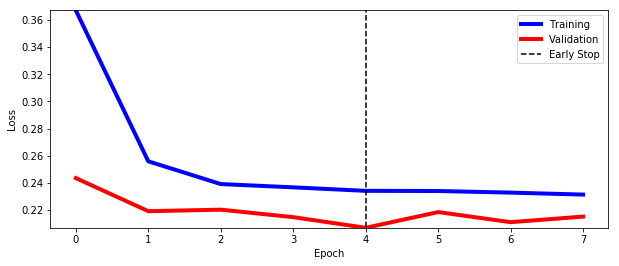

In [14]:
## Plot the learning curves for SPI1  
from dragonn.tutorial_utils import plot_learning_curve
plot_learning_curve(history_classification)

We now measure how well the model performed by calculating performance metrics on the test splits across the whole genome. 

In [15]:
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_classification_predictions=spi1_classification_model.predict_generator(spi1_test_classification_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_classification_truth=spi1_test_classification_gen.data

6047/6047 [==============================] - 322s 53ms/step


In [16]:
spi1_test_classification_predictions.shape

(6046528, 1)

In [17]:
spi1_test_classification_truth.shape

(6046528, 1)

In [18]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_truth.values.astype(bool),spi1_test_classification_predictions))

Loss: 0.1205	Balanced Accuracy: 89.46%	 auROC: 0.972	 auPRC: 0.217
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 20189	 Num Negatives: 6026339


In [25]:
#save the models 
spi1_classification_model.save("SPI1.classification.model.hdf5")

## Genome-wide regression model <a name='5'>
<a href=#outline>Home</a>

In [26]:
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=10,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=5,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(ntasks))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

(212239, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8830e2780>]],
      dtype=object)

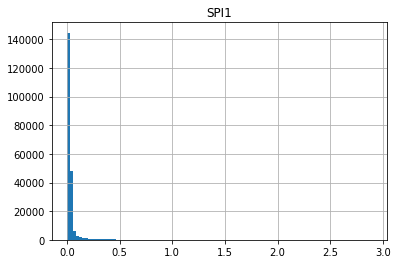

In [27]:
#we want to determine a threshold for upsampling the non-zero bins in a given batch 
# extract 5 million datapoints from the training data and observe the distribution of non-zero signal values  
sample=pd.read_hdf("SPI1.train.regression.hdf5",start=0,stop=5000000)
nonzero_sample=sample[sample.max(axis=1)>0]
print(nonzero_sample.shape)
nonzero_sample.hist(bins=100)

This suggests that 0.1 is a reasonable threshold for upsampling non-zero bins in regression 

In [28]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)


In [29]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 187s 19ms/step - loss: 0.0675 - val_loss: 0.0678
Epoch 2/150
10000/10000 [==============================] - 165s 16ms/step - loss: 0.0527 - val_loss: 0.0554
Epoch 3/150
10000/10000 [==============================] - 165s 16ms/step - loss: 0.0480 - val_loss: 0.0576
Epoch 4/150
10000/10000 [==============================] - 164s 16ms/step - loss: 0.0476 - val_loss: 0.0541
Epoch 5/150
10000/10000 [==============================] - 164s 16ms/step - loss: 0.0476 - val_loss: 0.0551
Epoch 6/150
10000/10000 [==============================] - 164s 16ms/step - loss: 0.0475 - val_loss: 0.0571
Epoch 7/150
10000/10000 [==============================] - 164s 16ms/step - loss: 0.0468 - val_loss: 0.0584


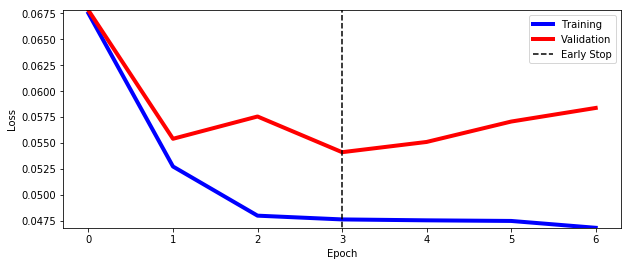

In [30]:
plot_learning_curve(history_regression)

In [31]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 335s 55ms/step


In [32]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.19701391], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.14151603717807051, pvalue=0.0)


In [ ]:
#There is some overfitting, let's save this model and see if we can do better 
spi1_regression_model.save("SPI1.regression.model.hdf5")

## Adding a fully connected layer for the regression model 

In [34]:
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=(1,1000,4)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(1,35)))

    model.add(Conv2D(filters=10,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=5,kernel_size=(1,10)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    
    model.add(Dense(500)) ###### NEW DENSE LAYER ADDED ##### 
    model.add(Activation('relu'))
    
    model.add(Dense(ntasks))

    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss='mse')
    return model

In [35]:
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)


In [36]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 195s 19ms/step - loss: 0.0553 - val_loss: 0.0551
Epoch 2/150
10000/10000 [==============================] - 176s 18ms/step - loss: 0.0469 - val_loss: 0.0540
Epoch 3/150
10000/10000 [==============================] - 176s 18ms/step - loss: 0.0464 - val_loss: 0.0520
Epoch 4/150
10000/10000 [==============================] - 175s 18ms/step - loss: 0.0462 - val_loss: 0.0511
Epoch 5/150
10000/10000 [==============================] - 176s 18ms/step - loss: 0.0457 - val_loss: 0.0520
Epoch 6/150
10000/10000 [==============================] - 177s 18ms/step - loss: 0.0461 - val_loss: 0.0509
Epoch 7/150
10000/10000 [==============================] - 176s 18ms/step - loss: 0.0459 - val_loss: 0.0507
Epoch 8/150
10000/10000 [==============================] - 185s 19ms/step - loss: 0.0457 - val_loss: 0.0510
Epoch 9/150
10000/10000 [==============================] - 177s 18ms/step - loss: 0.0452 - val_loss: 0.0531
Epoch 10/150
10000/10000 [==

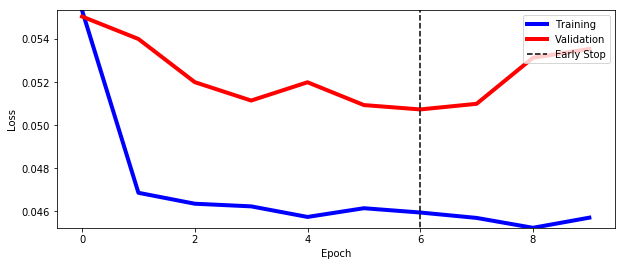

In [37]:
plot_learning_curve(history_regression)

In [38]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 343s 57ms/step


In [39]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.16536], dtype=float32), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.14595153956155055, pvalue=0.0)


## Regression on non-zero bins only  

In [40]:
train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.nonzero.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.nonzero.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.nonzero.regression.hdf5",
    'store_values_above_thresh':0,
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':False,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(test_set_params)


creating dictionary of bed files and bigwig files for each task:
SPI1
creating chromosome thread pool
launching thread pool
pre-allocated df for chrom:chr9with dimensions:(2824249, 4)
starting chromosome:chr9 for task:SPI1
pre-allocated df for chrom:chr5with dimensions:(3618286, 4)
starting chromosome:chr5 for task:SPI1
finished chromosome:chr9 for task:SPI1
pre-allocated df for chrom:chr3with dimensions:(3960429, 4)
pre-allocated df for chrom:chr7with dimensions:(3182754, 4)
starting chromosome:chr3 for task:SPI1
starting chromosome:chr7 for task:SPI1
finished chromosome:chr5 for task:SPI1
pre-allocated df for chrom:chr10with dimensions:(2710675, 4)
finished chromosome:chr3 for task:SPI1
starting chromosome:chr10 for task:SPI1
finished chromosome:chr7 for task:SPI1
finished chromosome:chr10 for task:SPI1
pre-allocated df for chrom:chr6with dimensions:(3422282, 4)
starting chromosome:chr6 for task:SPI1
pre-allocated df for chrom:chr8with dimensions:(2927261, 4)
starting chromosome:chr8

In [43]:
spi1_train_regression_gen=DataGenerator("SPI1.SPI1.train.nonzero.regression.hdf5","hg19.genome.fa.gz",upsample=False)
spi1_valid_regression_gen=DataGenerator("SPI1.SPI1.valid.nonzero.regression.hdf5","hg19.genome.fa.gz",upsample=False)



In [45]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  epochs=150,
                                                  steps_per_epoch=10000,
                                                  validation_steps=10000,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 205s 20ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 2/150
10000/10000 [==============================] - 183s 18ms/step - loss: 0.0241 - val_loss: 0.0238
Epoch 3/150
10000/10000 [==============================] - 191s 19ms/step - loss: 0.0245 - val_loss: 0.0236
Epoch 4/150
10000/10000 [==============================] - 183s 18ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 5/150
10000/10000 [==============================] - 183s 18ms/step - loss: 0.0239 - val_loss: 0.0235
Epoch 6/150
10000/10000 [==============================] - 192s 19ms/step - loss: 0.0242 - val_loss: 0.0236
Epoch 7/150
10000/10000 [==============================] - 195s 20ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 8/150
10000/10000 [==============================] - 191s 19ms/step - loss: 0.0240 - val_loss: 0.0236


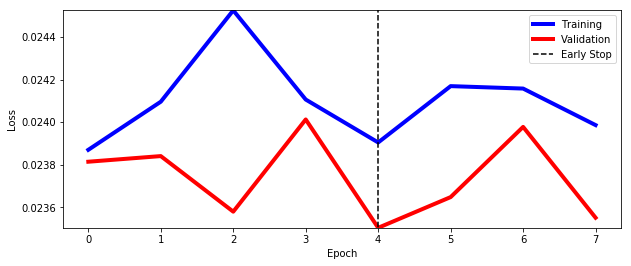

In [46]:
plot_learning_curve(history_regression)

In [47]:
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
spi1_test_regression_truth=spi1_test_regression_gen.data

6047/6047 [==============================] - 331s 55ms/step


In [48]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_truth,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_truth,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([3.8404686e-08], dtype=float32), array([0.99992265]))
Spearman correlation on test set:SpearmanrResult(correlation=nan, pvalue=nan)


## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='6'>
<a href=#outline>Home</a>

In [49]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
spi1_test_classification_truth_bool=spi1_test_classification_truth.values.astype(bool)
true_pos_spi1=spi1_test_classification_truth[spi1_test_classification_truth_bool*spi1_test_classification_predictions >0.9]
true_pos_spi1.head

<bound method NDFrame.head of                          SPI1
CHR   START    END           
chr2  191500   192500     1.0
      191550   192550     1.0
      191600   192600     1.0
      257050   258050     1.0
      257100   258100     1.0
      257150   258150     1.0
      257200   258200     1.0
      268950   269950     1.0
      269000   270000     1.0
      269050   270050     1.0
      269100   270100     1.0
      464500   465500     1.0
      464550   465550     1.0
      464600   465600     1.0
      464650   465650     1.0
      735500   736500     1.0
      735550   736550     1.0
      735600   736600     1.0
      735650   736650     1.0
      1135200  1136200    1.0
      1135250  1136250    1.0
      1135300  1136300    1.0
      1135350  1136350    1.0
      2274850  2275850    1.0
      2274900  2275900    1.0
      2274950  2275950    1.0
      2275000  2276000    1.0
      2625200  2626200    1.0
      2625250  2626250    1.0
      2694100  2695100    1.0
...       

In [50]:
true_pos_spi1.shape

(5729, 1)

In [51]:
from dragonn.utils import one_hot_from_bed
deep_lift_input_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
deep_lift_input_spi1.shape

(5729, 1, 1000, 4)

In [52]:
from dragonn.tutorial_utils import deeplift 

In [53]:
deep_lift_scores_spi1=deeplift(spi1_classification_model,deep_lift_input_spi1)

In [54]:
deep_lift_scores_spi1.shape

(5729, 1, 1000, 4)

Let's plot a few of the DeepLIFT tracks and see if the model successfully learned SPI1:

In [55]:
from dragonn.tutorial_utils import  plot_seq_importance

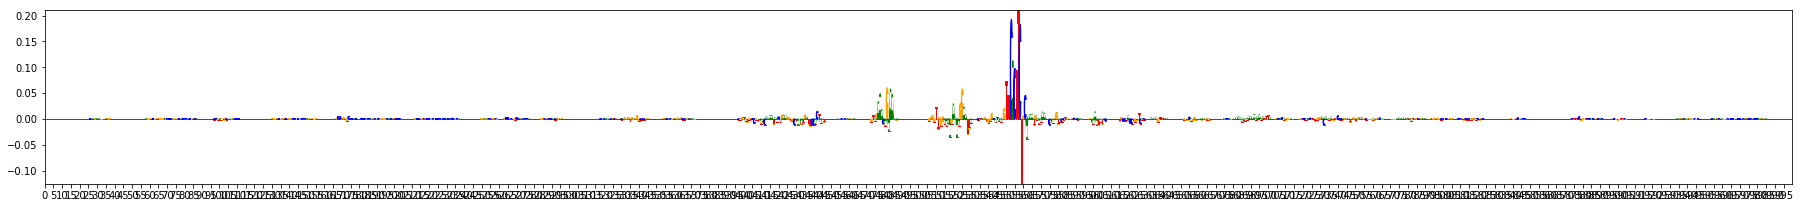

In [56]:
plot_seq_importance(deep_lift_scores_spi1[0],deep_lift_input_spi1[0])

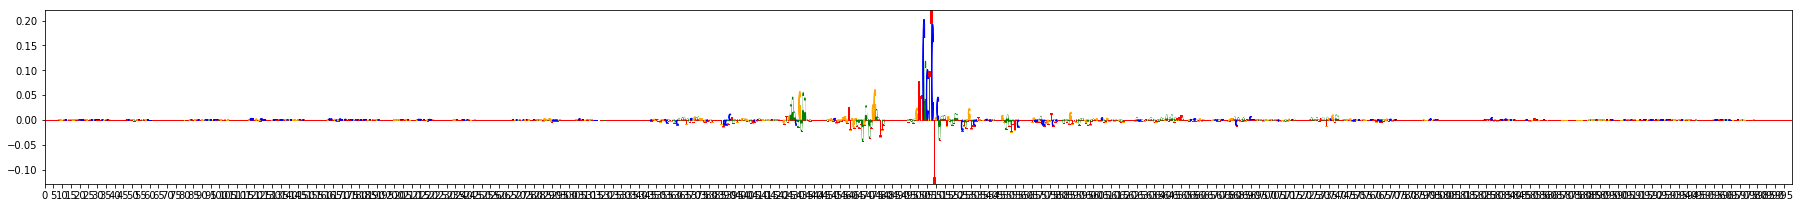

In [57]:
plot_seq_importance(deep_lift_scores_spi1[1],deep_lift_input_spi1[1])

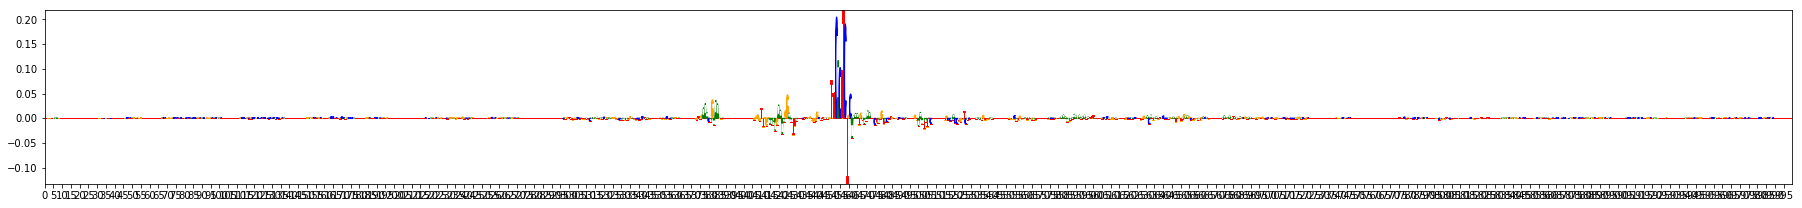

In [59]:
plot_seq_importance(deep_lift_scores_spi1[2],deep_lift_input_spi1[2])

Let's zoom in to the center of one sequence so that it is easier to distinguish the motif: 

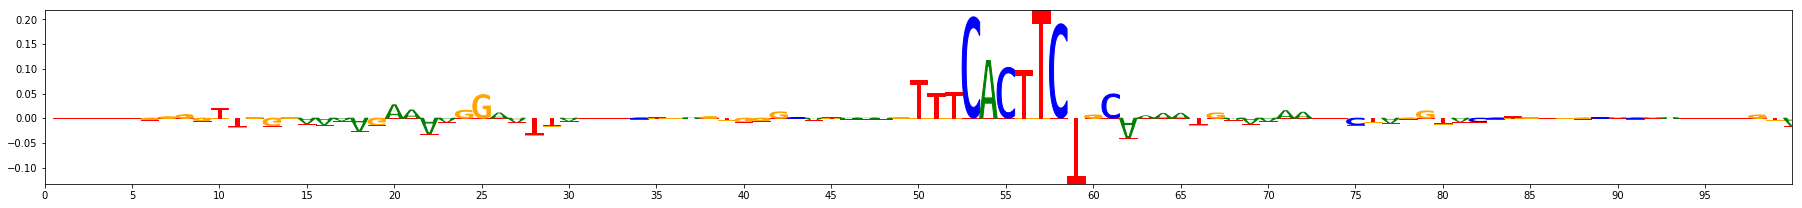

In [61]:
plot_seq_importance(deep_lift_scores_spi1[2].squeeze()[400:500],deep_lift_input_spi1[2].squeeze()[400:500])

If we query the sequence "GTTTCACTTC" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for IRF2, which is in the same motif family (Tryptophan cluster factors) as SPI1: 
<img src="tutorial_images/IRF.Tut4.png" alt="IRF2TomTom" width="400"/>


## Recovering bQTL effect sizes: Classification vs Regression <a name='7'>
<a href=#outline>Home</a>

In [13]:
from dragonn.generators import * 
bqtl_ref_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [14]:
bqtl_ref_classification_predictions=spi1_classification_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)

7811/7811 [==============================] - 68s 9ms/step


In [15]:
bqtl_alt_classification_predictions=spi1_classification_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_ref_classification_truth=bqtl_ref_gen.data['pvalue']

7811/7811 [==============================] - 69s 9ms/step


In [18]:
print(bqtl_ref_classification_predictions.shape)
print(bqtl_alt_classification_predictions.shape)
print(bqtl_ref_classification_truth.shape)

(999799, 1)
(999799, 1)
(999799,)


In [23]:
bqtl_ref_regression_predictions=spi1_regression_model.predict_generator(bqtl_ref_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)
bqtl_alt_regression_predictions=spi1_regression_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


7811/7811 [==============================] - 67s 9ms/step


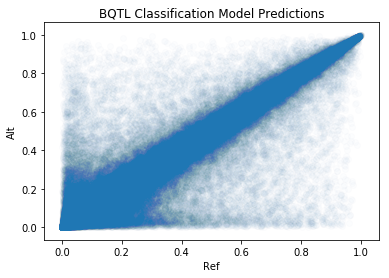

In [26]:
plt.scatter(bqtl_ref_classification_predictions, bqtl_alt_classification_predictions, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Classification Model Predictions")
plt.show()


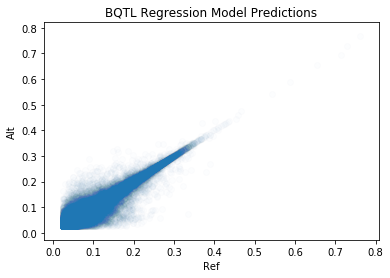

In [27]:
plt.scatter(bqtl_ref_regression_predictions, bqtl_alt_regression_predictions, alpha=0.01)
plt.xlabel("Ref")
plt.ylabel("Alt")
plt.title("BQTL Regression Model Predictions")
plt.show()

## Model-predicted SNP effect sizes vs bQTL effect sizes <a name='8'>
<a href=#outline>Home</a>

In [34]:
logpval=np.log10(bqtl_ref_classification_truth.values)
delta=bqtl_alt_classification_predictions-bqtl_ref_classification_predictions


## Conclusions <a name='9'>
<a href=#outline>Home</a>

## Save tutorial outputs <a name='10'>
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [33]:
#save the models 
spi1_classification_model.save("SPI1.classification.model.hdf5")
spi1_regression_model.save("SPI1.regression.model.hdf5")
#save the test predictions 
import h5py 
test_set_predictions=h5py.File("SPI1.test.predictions.hdf5",'w')
test_set_predictions.create_dataset("classification",data=spi1_test_classification_predictions)
test_set_predictions.create_dataset("regression",data=spi1_test_regression_predictions)
test_set_predictions.close() 
